<a href="https://colab.research.google.com/github/SAMAWELJABALLI/TweetsSentimentAnalysis/blob/main/EDA_and_datapreprocessing_for_tunisian_dialect_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. About Dataset

**Data Source2: https://www.kaggle.com/naim99/tunisian-texts**

* Number of reviews: 206,117
* Timespan: Aout 2020 - janvier 2021
* Number of Attributes/Columns in data: 3

**Tunisian-corpus-NLP-tasks باللهجة متاعنا**

2. Objective:

**Given a review, determine whether the review is positive or negative.**

* How to determine if a review is positive or negative?

We could use Score/Rating. A rating of 1 can be cosnidered as a positive review. A rating of -1  can be considered as negative one. A review of rating 0 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


#[1] Reading data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

**Set up GPU for training**

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

Runtime -> Change runtime type -> Hardware accelerator: GPU

Then we need to run the following cell to specify the GPU as the device.

In [2]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [3]:
# Load data and set labels from corpus 1 
data = pd.read_csv('/content/dialect tunisian corpus for sentiment Analysis with 3 classes.txt', lineterminator='\n')
print(f'Shape of data is {data.shape}')
# Display 20 random samples
data.sample(20)

Shape of data is (206117, 3)


,ID,text,label
169829,33712,nna3din zebbii lwaah lpuub,0
162883,26766,allah yara7mou w yar7amna a7na vive ca,1
38891,38891,kalab w frou5 tfoooooooooooooooooooooo,0
52625,2734,Toujours le même protblème une erreur est surv...,0
105845,55954,جوميا متعة التسوق,1
77198,27307,Je narrive pas à installer,2
61581,11690,A7la twensa w a7la mo7sen,1
8835,8835,<3,1
169766,33649,au moins howa sre9 men dowal okra w jabha ltou...,0
20492,20492,"""أكثر المناطق المتضررة بفيروس كورونا في تونس",1


In [4]:
data['label'].value_counts()

1    136821
0     62276
2      7020
Name: label, dtype: int64

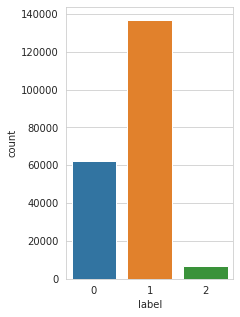

In [5]:
#Initial target distribuation 
target = data['label']
sns.set_style('whitegrid')
plt.figure(figsize=(3,5))
sns.countplot(target)

#[2] Exploratory data Analysis EDA
#**2.1 Data cleaning**

First we will check for missing values

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206117 entries, 0 to 206116
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      206117 non-null  int64 
 1   text    204452 non-null  object
 2   label   206117 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.7+ MB


We can see that we don't have any null values.

**Now we will check for duplicate entries**

In [7]:
print(data["text"].shape[0])
print(len(set(data['text'])))


206117
166449


With a hard mathemitical computing we can know that there is 206117-166449=39668 tweets which are duplicated :D

In [8]:
#Delet duplicated texts
df = data.drop_duplicates(subset=['text'],keep='first',inplace=False)
df.shape
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 80.75461994886399


#**2.2 Analysis on Score (Target Variable)**

Now we will create our target variable from review stars. Before that we will filter only those reviews with rating 1 (positive) and less than 0(negative)

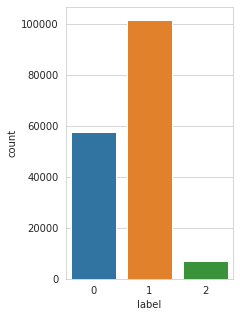

In [9]:
#Target distrubution after deleting duplicated texts 
target = df['label']
sns.set_style('whitegrid')
plt.figure(figsize=(3,5))
sns.countplot(target)

In [10]:
df = data[data['label'] != 2]
df.shape 
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 96.59416739036567


Let's check target distrubution

Check for Class Imbalance

In [11]:
df['label'].value_counts()

1    136821
0     62276
Name: label, dtype: int64

We have 136821 positive message and 62276 negative message

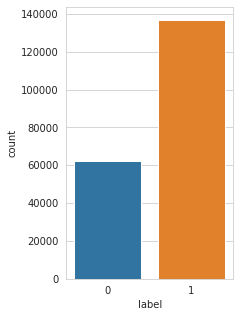

In [12]:
target = df['label']
sns.set_style('whitegrid')
plt.figure(figsize=(3,5))
sns.countplot(target)

**Observation**: It is clear that we have an imbalenced dataset for classification. So We cannot choose accuracy as a metric. So here we will go with AUC(Area under ROC curve)

>* Why accuracy not for imbalanced datasets?

Consider a scenario like this where we have imbalenced dataset. For example consider case of credit card fraud detection with 98% percentage of points as non-fraud(1) and rest 2% points as fraud(1). In such cases even if we predict all the points as non-fraud also we will get 98% accuracy. But actually it is not the case. So we can't use accuracy as a metric.

>* What is AUC ROC?

AUC is the area under ROC curve.It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,199097.0,28095.528406,18104.177292,0.0,12786.0,25582.0,42395.0,69999.0
label,199097.0,0.687208,0.463632,0.0,0.0,1.0,1.0,1.0


In [14]:
df.groupby('label').describe()

ID                             ...                           
          count         mean           std  ...      50%      75%      max
label                                       ...                           
0       62276.0  34712.06688  17293.326290  ...  37913.5  47127.0  69998.0
1      136821.0  25083.91798  17658.743888  ...  21379.0  36188.0  69999.0

[2 rows x 8 columns]

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of negativetive detection in general.

In [15]:
df['text'] =df['text'].astype(str)
df['message_len'] = df.text.apply(len)
df.head()

,ID,text,label,message_len
0,0,yar777em weldin weldikk bravooooo,1,33
1,1,Bravo amine...j'aime,1,20
2,2,صراحة bravo أحمد الرحموني .,1,27
3,3,Souut w ziiin lee wlh bch tda5llouna f 7iiit,1,44
4,4,ANAA N7bha,1,10


Text(0.5, 0, 'Message Length')

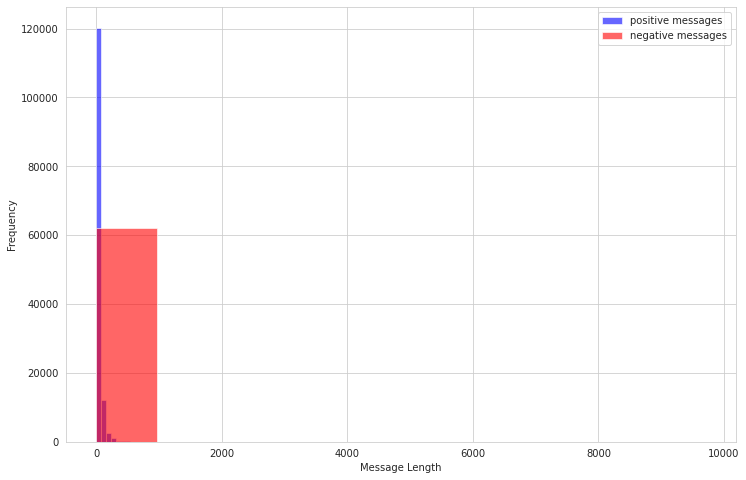

In [16]:
plt.figure(figsize=(12, 8))

df[df.label==1].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='positive messages', alpha=0.6)
df[df.label==0].message_len.plot(kind='hist', color='red', 
                                       label='negative messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

**Very interesting! Through just basic EDA we've been able to discover a trend that negatives messages tend to have more characters. :D**

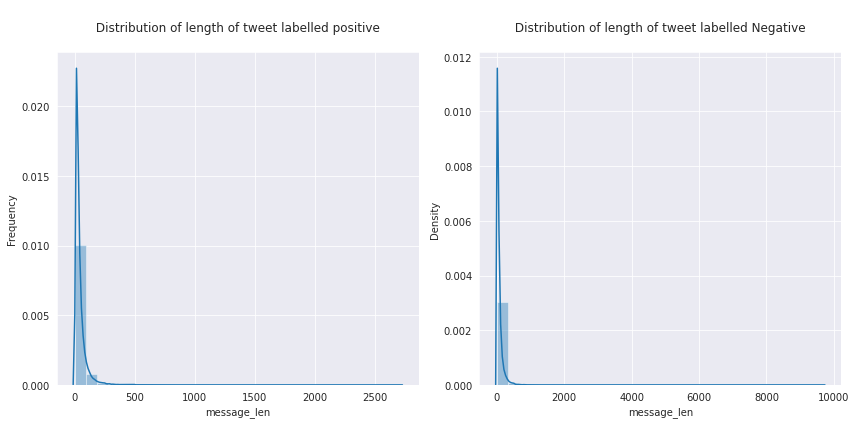

In [17]:
#creating subplots to see distribution of length of tweet
sns.set_style("darkgrid");
f, (ax1, ax2) = plt.subplots(figsize=(12,6),nrows=1, ncols=2,tight_layout=True);
sns.distplot(df[df['label']==1]["message_len"],bins=30,ax=ax1);
sns.distplot(df[df['label']==0]["message_len"],bins=30,ax=ax2);
ax1.set_title('\n Distribution of length of tweet labelled positive \n');
ax2.set_title('\n Distribution of length of tweet labelled Negative \n');
ax1.set_ylabel('Frequency');

In [18]:
df[df.label==1].describe()

,ID,label,message_len
count,136821.000000,136821.0,136821.000000
mean,25083.917980,1.0,41.743183
std,17658.743888,0.0,53.562693
min,0.000000,1.0,1.000000
25%,10700.000000,1.0,15.000000
50%,21379.000000,1.0,26.000000
75%,36188.000000,1.0,48.000000
max,69999.000000,1.0,2714.000000


In [19]:
df[df.label==0].describe()

,ID,label,message_len
count,62276.00000,62276.0,62276.000000
mean,34712.06688,0.0,72.899287
std,17293.32629,0.0,103.891915
min,2.00000,0.0,1.000000
25%,22533.75000,0.0,22.000000
50%,37913.50000,0.0,43.000000
75%,47127.00000,0.0,87.000000
max,69998.00000,0.0,9700.000000


In [20]:
#Woah! 2714 characters, let's use masking to find this message //// the longest positive tweet
#data[data.message_len == 1002].texts.tolist()
df[df.message_len == 2714].text.iloc[0]

'bravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bravobravo bra

In [21]:
# the same, 9700 characters, let's use masking to find this message //// the longest negative tweet
df[df.message_len == 9700].text.iloc[0]

'paroles wadha3 fih tetsdam khayf tetrdm moush ena li n9oull 7a9 w kima ghiri netrdem ncharef tashkila w 7wom ebda3at bl kam drapeauwat nhez w ken lzaz khalana fl ham sara7 nahki tala3 habt dima khaydh 100 mn khotta fy rassi 3al 3waj 9albi faydh tayr wnty baydh mabroumk lena mayroll 3aysh fawdha ki baghded w moshkoltk tetsama 3andi 7al 7keytk 7wal shaba3 menniken 7alat mshni nawi n3ish rajl kifk b kamsha jamet lokza fy colon jamed w m3a rohk mat hanish l far9 bini w bink li 3andk maye3jbnish f9ir w n7eb n3ish yal 3abd esami3 baba moush bousbi3 w mshna besh net7asbou jmi3 ma3shnash bl talmi3 w makontsh stable matshoufnish passable w la kifhom nos5a jeutable taba3fih tansa5 w 9abl m3awnk fl sif domainy ro9ya shar3eya wnty tsarbi fl zfif king wmsh bl kif nkhali fi amjad w kank 3la rasi yarfa3 shika moush 3bad abyedh w naswer w nseb loudhen etarsha manishi zabour w n7awl mankounsh mnayk barsha dima raba7 barsha w 3ati 100 mn dars w takhra 3la rou7k kan tshouf zebi mkarz maksh ki booba bash

# **2.3 Check Text Content for corpus**


In [22]:
df["text"].head(10)


0                    yar777em weldin weldikk bravooooo
1                                 Bravo amine...j'aime
2                          صراحة bravo أحمد الرحموني .
3         Souut w ziiin lee wlh bch tda5llouna f 7iiit
4                                           ANAA N7bha
5                                      Bravooooo walid
6                                    محترم و نموة علها
7             ربي يشفيلك بوك،وان شاء الله غصرة وتتعدى،
8    Bravoooooooooooooooo w5ali nabara 3la jnab rak...
9                                                Bravo
Name: text, dtype: object


It's clear that the rest of the texts are hided because of the test length, I will put the column in a list to check the first 5 texts

In [23]:
#To check the text content we can use a list
df["text"].tolist()[:10]

['yar777em weldin weldikk bravooooo',
 "Bravo amine...j'aime",
 'صراحة bravo أحمد الرحموني .',
 'Souut w ziiin lee wlh bch tda5llouna f 7iiit',
 'ANAA N7bha',
 'Bravooooo walid',
 'محترم و نموة علها',
 'ربي يشفيلك بوك،وان شاء الله غصرة وتتعدى،',
 'Bravoooooooooooooooo w5ali nabara 3la jnab rak wa7dik m3alim',
 'Bravo']

**Let's make it more perfect**


In [24]:
t = df["text"].to_list()
for i in range(10):
    print('Tweet Number '+str(i+1)+': '+t[i])

Tweet Number 1: yar777em weldin weldikk bravooooo
Tweet Number 2: Bravo amine...j'aime
Tweet Number 3: صراحة bravo أحمد الرحموني .
Tweet Number 4: Souut w ziiin lee wlh bch tda5llouna f 7iiit
Tweet Number 5: ANAA N7bha
Tweet Number 6: Bravooooo walid
Tweet Number 7: محترم و نموة علها
Tweet Number 8: ربي يشفيلك بوك،وان شاء الله غصرة وتتعدى،
Tweet Number 9: Bravoooooooooooooooo w5ali nabara 3la jnab rak wa7dik m3alim
Tweet Number 10: Bravo


**frequent positives words**

In [25]:
#most 50 frequent positives words
words = df[df.label==1].text.apply(lambda x: [word.lower() for word in x.split()])
positive_words = Counter()

for msg in words:
    positive_words.update(msg)
    
positive_words.most_common(50)


[('w', 10438),
 ('و', 9836),
 ('rabi', 6740),
 ('ya', 6689),
 ('et', 6587),
 ('de', 6385),
 ('ربي', 6165),
 ('في', 5850),
 ('الله', 5603),
 ('bravo', 4984),
 ('من', 4469),
 ('fi', 4356),
 ('la', 4218),
 ('slim', 4215),
 ('je', 4156),
 ('le', 4119),
 ('très', 3758),
 ('el', 3690),
 ('les', 3626),
 ('jumia', 3286),
 ('application', 3263),
 ('pour', 3146),
 ('bonne', 3023),
 ('à', 2863),
 ('a', 2715),
 ('si', 2714),
 ('merci', 2713),
 ('[ربي', 2713),
 ('est', 2595),
 ('cest', 2524),
 ('على', 2478),
 ('m3ak', 2437),
 ('جدا', 2435),
 ('en', 2430),
 ('bien', 2402),
 ('ca', 2321),
 ('bon', 2289),
 ('des', 2266),
 ('vous', 2237),
 ('pas', 2194),
 ('يا', 2163),
 ('kol', 2144),
 ('il', 2053),
 ('كل', 2031),
 ('allah', 2014),
 ('تونس', 1933),
 ('slouma', 1930),
 ('un', 1911),
 ('que', 1898),
 ('une', 1883)]

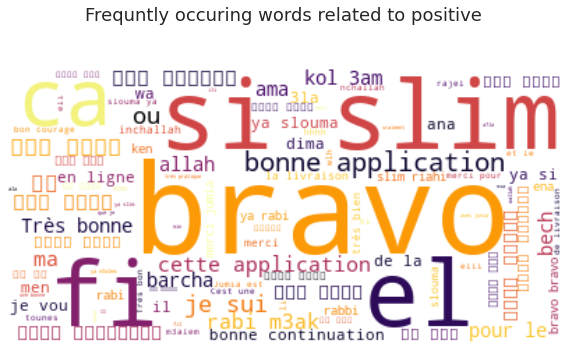

In [26]:
# word cloud for words related to positive (most 100 frequent)
text=" ".join(post for post in df[df['label']==1].text)
wordcloud = WordCloud(max_font_size=90, max_words=100, background_color="white", colormap="inferno").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Frequntly occuring words related to positive \n\n',fontsize=18)
plt.axis("off")
plt.show()

**frequent negatives words**

In [27]:
#most 50 frequent negatives words
words = df[df.label==0].text.apply(lambda x: [word.lower() for word in x.split()])
positive_words = Counter()

for msg in words:
    positive_words.update(msg)
    
positive_words.most_common(50)


[('w', 11512),
 ('و', 8652),
 ('de', 5732),
 ('fi', 5537),
 ('el', 4707),
 ('في', 4614),
 ('ya', 4276),
 ('la', 4144),
 ('pas', 3814),
 ('من', 3509),
 ('le', 3427),
 ('et', 3309),
 ('je', 3051),
 ('slim', 2563),
 ('les', 2523),
 ('a', 2353),
 ('ne', 2235),
 ('ma', 2226),
 ('il', 2114),
 ('l', 2112),
 ('des', 2008),
 ('bech', 2003),
 ('ken', 1986),
 ('à', 1959),
 ('que', 1922),
 ('على', 1836),
 ('vous', 1792),
 ('ما', 1774),
 ('3la', 1733),
 ('un', 1645),
 ('لا', 1644),
 ('est', 1593),
 ('ou', 1570),
 ('pour', 1532),
 ('en', 1502),
 ('si', 1496),
 ('une', 1491),
 ('men', 1407),
 ('الي', 1386),
 ('application', 1319),
 ('kol', 1287),
 ('plus', 1275),
 ('eli', 1264),
 ('mais', 1234),
 ('rabi', 1192),
 ('يا', 1187),
 ('jai', 1185),
 ('الله', 1139),
 ('ki', 1137),
 ('cest', 1127)]

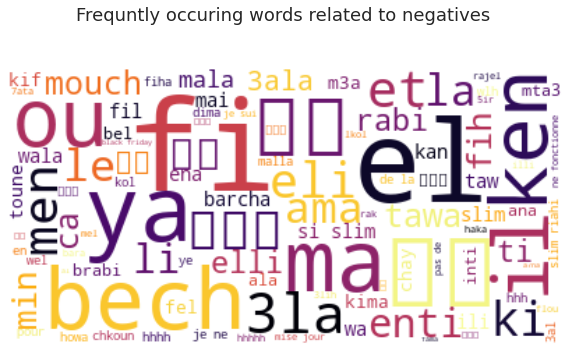

In [28]:
# word cloud for words related to negatives (most 100 frequent)
text=" ".join(post for post in df[df['label']==0].text)
wordcloud = WordCloud(max_font_size=90, max_words=100, background_color="white", colormap="inferno").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Frequntly occuring words related to negatives \n\n',fontsize=18)
plt.axis("off")
plt.show()

#[3]. Preprocessing Text data
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

* Begin by removing the html tags
* Remove any punctuations or limited set of special characters like , or . or # etc.
* Check if the word is made up of english letters and is not alpha-numeric
* Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
* Convert the word to lowercase
* Remove Stopwords

In [29]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
%%time
# replacing some phrases like je peux pas with je ne peux pas
def decontracted(phrase):
    # specific
    phrase = re.sub(r"je peux pas", "je ne peux pas", phrase)
    phrase = re.sub(r"j'aime pas", "je ne aime pas", phrase)
    return phrase

perstopwords= set(['et','el','al','wa', 'si'])

def  text_preprocessing(df, text_field, new_text_field_name):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """   
    df[new_text_field_name] = df[text_field].str.lower()
    # Change 't to 'not'
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: re.sub(r"\' t", " not", s))
    # Change n' to 'ne'
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: re.sub(r"\n'", " ne", s)) 
    # Remove @name
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: re.sub(r'(@.*?)[\s]', ' ', s))
    # decontracted sentences
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: decontracted(s))
    # removing extra spaces and numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: re.sub("\S*\d\S*", "", s).strip())
    # Isolate and remove punctuations except '?'
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: re.sub(r'[^\w\s\?]', ' ', s))
    # Remove some special characters
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: re.sub(r'([\;\:\|•«\n])', ' ', s))
    # Remove stopwords except 'not' and 'can'
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: " ".join([word for word in s.split() if word not in stopwords.words('english') or word in ['not', 'can']]))
    # Remove trailing whitespace
    df[new_text_field_name] = df[new_text_field_name].apply(lambda s: re.sub(r'\s+', ' ', s).strip())
    return df
data_clean = text_preprocessing(df, 'text', 'text_clean')

CPU times: user 2min 42s, sys: 17.9 s, total: 3min
Wall time: 3min


In [31]:
data_clean.head()

,ID,text,label,message_len,text_clean
0,0,yar777em weldin weldikk bravooooo,1,33,weldin weldikk bravooooo
1,1,Bravo amine...j'aime,1,20,bravo amine j aime
2,2,صراحة bravo أحمد الرحموني .,1,27,صراحة bravo أحمد الرحموني
3,3,Souut w ziiin lee wlh bch tda5llouna f 7iiit,1,44,souut w ziiin lee wlh bch f
4,4,ANAA N7bha,1,10,anaa


In [32]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199097 entries, 0 to 206116
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           199097 non-null  int64 
 1   text         199097 non-null  object
 2   label        199097 non-null  int64 
 3   message_len  199097 non-null  int64 
 4   text_clean   199097 non-null  object
dtypes: int64(3), object(2)
memory usage: 14.1+ MB


In [33]:
data_clean.shape

(199097, 5)

In [34]:
#save our clean dataframe into csv file
data_clean.to_csv ('data_clean.csv')

# [4]. Split the data to train and test data



In [35]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
X = data_clean['text_clean']
y = data_clean['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (139367,)
shape of X_test is (59730,)
shape of y_train is (139367,)
shape of y_test is (59730,)


**140k for train and 60k for test and validation :D**


In [37]:
np.save('saved_feats/X_train', X_train)
np.save('saved_feats/y_train', y_train)
np.save('saved_feats/X_test', X_test)
np.save('saved_feats/y_test', y_test)

#[5].Text Vectorization

# 5.1 Text Vectorization using Bag of Words



In [38]:
%%time

bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (139367, 144497)
shape of X_test_bow is (59730, 144497)
CPU times: user 4.6 s, sys: 47.9 ms, total: 4.65 s
Wall time: 4.67 s


In [39]:
#saving bow vectors
import pickle
pickle.dump(X_train_bow, open("saved_feats/X_train_bow","wb"))
pickle.dump(X_test_bow, open("saved_feats/X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("saved_feats/bow_features","wb"))

#5.2 Text Vectorization using TF-IDF 

In [40]:
%%time
#applying bow on x_train and x_test
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
tfidf_features = vectorizer.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

CPU times: user 4.97 s, sys: 51.6 ms, total: 5.02 s
Wall time: 5.04 s


In [41]:
#saving tfidf vectors
pickle.dump(X_train_tfidf, open("saved_feats/X_train_tfidf","wb"))
pickle.dump(X_test_tfidf, open("saved_feats/X_test_tfidf","wb"))
pickle.dump(np.array(tfidf_features), open("saved_feats/tfidf_features","wb"))

# 5.3 Text Vectorization using Word2Vec

In [42]:
%%time
preprocessed_reviews = X_train.values
train_sentence = [rev.split() for rev in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model_train.wv.vocab)

CPU times: user 25 s, sys: 281 ms, total: 25.2 s
Wall time: 16.8 s


In [43]:
pickle.dump(np.array(w2v_words),open("saved_feats/w2v_words","wb"))

# 5.4 Text Vectorization using Average Word2vec

In [44]:
%%time
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]

sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

########################################################
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]

sent_vectors_test = []
for sent in tqdm(test_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

  0%|          | 0/59730 [00:00<?, ?it/s]

139367
50


100%|██████████| 59730/59730 [02:16<00:00, 437.35it/s]

59730
50
CPU times: user 7min 30s, sys: 9.77 s, total: 7min 39s
Wall time: 7min 32s


In [45]:
X_train_avgw2v = np.array(sent_vectors_train)
X_test_avgw2v = np.array(sent_vectors_test)

pickle.dump(np.array(X_train_avgw2v), open("saved_feats/X_train_avgw2v","wb"))
pickle.dump(np.array(X_test_avgw2v), open("saved_feats/X_test_avgw2v","wb"))

# 5.4 Text Vectorization using Tfidf Word2Vec

In [46]:
%%time
w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

#saving
pickle.dump(np.array(tfidf_feats), open("saved_feats/X_train_tfw2v","wb"))

CPU times: user 3.41 s, sys: 844 ms, total: 4.26 s
Wall time: 4.52 s


In [47]:
%%time
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])

X_train_tfw2v = sent_vectors_train
pickle.dump(np.array(X_train_tfw2v), open("saved_feats/X_train_tfw2v","wb"))

100%|██████████| 139367/139367 [2:11:05<00:00, 17.72it/s]


139367
[-1.34891455 -0.56303944 -0.51066301  0.89996312  1.34982633  0.97607324
  0.80014245 -0.42963558 -2.33140338 -0.19019399 -0.24339184  0.20400641
  2.62947221 -0.22290862  0.08819142 -0.77020423 -1.05744472 -2.43090935
  1.10378831 -1.27240045 -0.15047679  0.45002849 -0.64127093  0.41491459
 -0.74816535  0.97802358  0.20367413  0.81096737 -1.21772527  0.38133403
  1.40920999  0.36415477 -1.67204272  0.39856308 -1.57524387  0.41490848
  0.78514736 -1.21568107 -0.83718457  0.2384681  -2.66853613 -0.27857429
  0.11328408  0.32810586  0.35395891 -0.01794103  1.19764119  0.16321532
 -0.45884235 -1.52909058]
CPU times: user 2h 9min 56s, sys: 46 s, total: 2h 10min 42s
Wall time: 2h 11min 6s


In [48]:
%%time 
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(sent_vectors_test[0])

100%|██████████| 59730/59730 [57:19<00:00, 17.36it/s]

59730
[-1.66908795 -0.10035234 -0.8624258   0.34141208  0.60082334  0.03149977
  0.4508842  -0.48011515 -1.64054142  0.76280134 -0.82370268  0.33382418
  2.55343009  0.46339624 -0.45234053 -0.28847632 -0.7016781  -1.25202828
  0.99974505 -0.94749079 -0.26771444 -0.0922268  -0.70822337 -0.10739045
 -1.60028595  0.13862792  0.55055688  0.44241494 -0.30939804  0.33780337
  0.81380709  1.15474618 -1.74304816  0.69370537 -0.61066375  0.04567846
  0.76167975 -0.55989057 -0.35103018  0.28884256 -1.29808819  0.38103336
  0.14313635  0.61518709 -0.0475784  -0.78294526  1.4964455   0.03399268
 -0.15317341 -0.5781442 ]
CPU times: user 56min 58s, sys: 17.7 s, total: 57min 16s
Wall time: 57min 20s


In [49]:
X_test_tfw2v = sent_vectors_test
pickle.dump(np.array(X_test_tfw2v), open("saved_feats/X_test_tfw2v","wb"))

#[6]. Loading saved vectors


In [50]:
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (139367, 144497)
shape of X_test_bow is (59730, 144497)
shape of X_train_tfidf is (139367, 144497)
shape of X_test_tfidf is (59730, 144497)
shape of X_train_avgw2v is (139367, 50)
shape of X_test_avgw2v is (59730, 50)
shape of X_train_tfw2v is (139367, 50)
shape of X_test_tfw2v is (59730, 50)
shape of y_train is (139367,)
shape of y_test is (59730,)
